# <center><H1>Smart City: Traffic prediction using Deep Learning</H1></center>
                     
         
                      Randa Mohammed            Leena AlQasem               Banan Alhethlool 
                    randa1414@gmail.com       Leenabdulh@gmail.com       banan.alhethlool@gmail.com

## Table of content: 

  * [Import Libraries](#first)
  * [Data Exploration and Assessing](#second)
  * [Feature Engineeringt](#Third)
  * [EDA](#Forth)
  * [Normalization and Differencing](#Fifth)
  * [Splitting data for training and testing sets](#sixth)
  * [Modeling](#seventh)

## Importing libreries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from math import sqrt
import tensorflow
from tensorflow import keras
from statsmodels.tsa.stattools import adfuller
from keras import callbacks
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

## Data Exploration and Assessing

In [2]:
df_traffic = pd.read_csv("traffic.csv")

In [3]:
df_traffic.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
print(f"- The dataset containes {df_traffic.shape[0]} employees records with {df_traffic.shape[1]} columns.")
print('\n*****************************************************\n')

print(f"\n- The columns data type:\n{df_traffic.dtypes}") 
print('\n*****************************************************\n')

print(f"\n- Number of null values:\n{df_traffic.isnull().sum()}")
print('\n*****************************************************\n')

print(f"\n- Number of duplicates values:\n{df_traffic.duplicated().sum()}")
print('\n*****************************************************\n')

print("\n- The dataset inforomation:\n")
df_traffic.info()

- The dataset containes 48120 employees records with 4 columns.

*****************************************************


- The columns data type:
DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

*****************************************************


- Number of null values:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

*****************************************************


- Number of duplicates values:
0

*****************************************************


- The dataset inforomation:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [5]:
df_traffic.Junction.value_counts()

1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64

In [6]:
df_traffic.Junction.value_counts() / len(df_traffic) * 100

1    30.324190
2    30.324190
3    30.324190
4     9.027431
Name: Junction, dtype: float64

***

## Feature Engineering

1. Formatting the Datetime

In [7]:
df_traffic["DateTime"]= pd.to_datetime(df_traffic["DateTime"])

df_traffic["Year"]= df_traffic['DateTime'].dt.year
df_traffic["Month"]= df_traffic['DateTime'].dt.month
df_traffic["Day_Num"]= df_traffic['DateTime'].dt.day
df_traffic["Hour"]= df_traffic['DateTime'].dt.hour
df_traffic["Day"]= df_traffic.DateTime.dt.strftime("%A")
df_traffic['Year_Quarter'] = df_traffic['DateTime'].dt.quarter
df_traffic.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Day_Num,Hour,Day,Year_Quarter
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday,4
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday,4
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday,4
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday,4
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday,4


2. Dropping unecessary columns

In [8]:
df_traffic.drop(['ID'], axis='columns', inplace=True)

In [9]:
df_traffic.head()

,DateTime,Junction,Vehicles,Year,Month,Day_Num,Hour,Day,Year_Quarter
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday,4
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday,4
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday,4
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday,4
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday,4


In [10]:
df_edited = df_traffic[['Junction', 'Vehicles','Year','Month','Day_Num','Hour','Day','Year_Quarter']]
df_edited.head()

,Junction,Vehicles,Year,Month,Day_Num,Hour,Day,Year_Quarter
0,1,15,2015,11,1,0,Sunday,4
1,1,13,2015,11,1,1,Sunday,4
2,1,10,2015,11,1,2,Sunday,4
3,1,7,2015,11,1,3,Sunday,4
4,1,9,2015,11,1,4,Sunday,4


In [11]:
df_traffic.Year.value_counts()

2016    26352
2017    17376
2015     4392
Name: Year, dtype: int64

***

## EDA

1. Plot the distribution of data in junction

In [12]:
def histogram(junction=1):
    data = df_traffic[df_traffic['Junction'] == junction]
    f, ax = plt.subplots(figsize=(17, 5))
    ax = sns.histplot(data['Vehicles'], kde=True, stat='probability')
    ax.set_title(f'Plot show the distribution of data in junction {junction}')
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

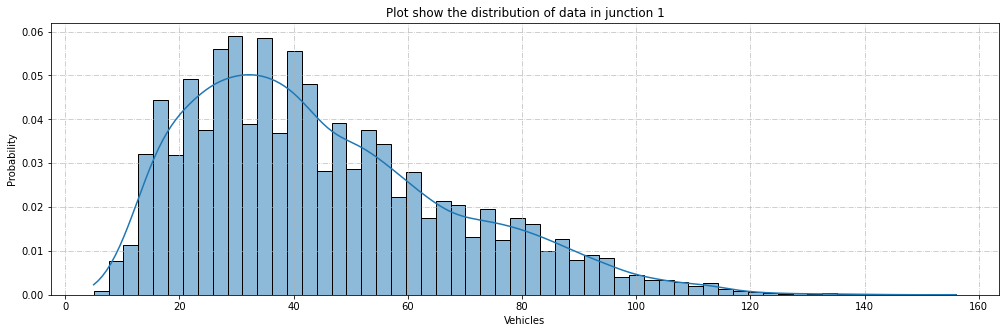

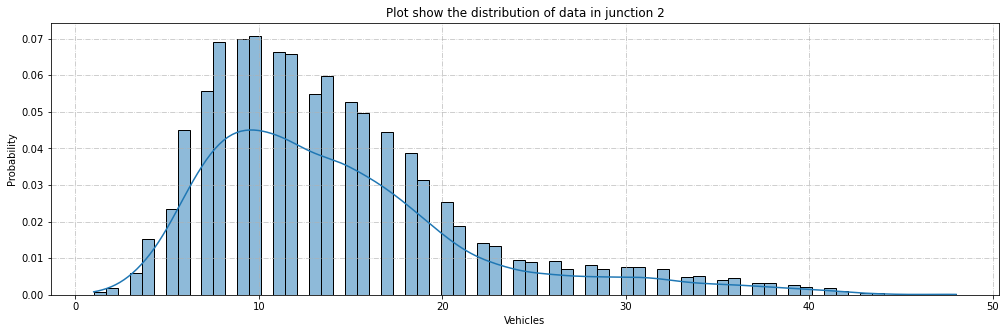

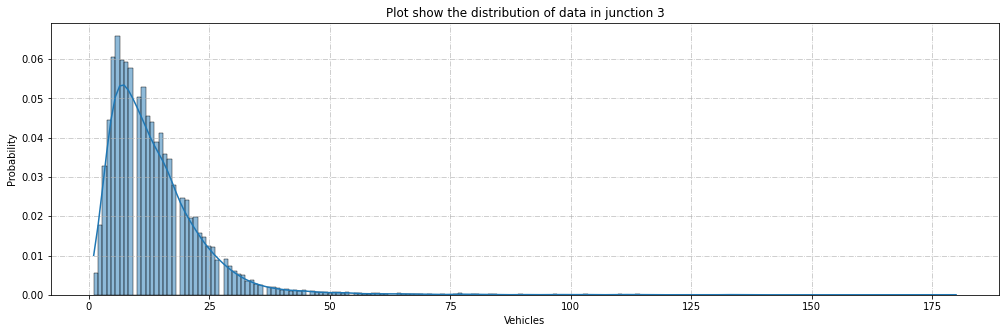

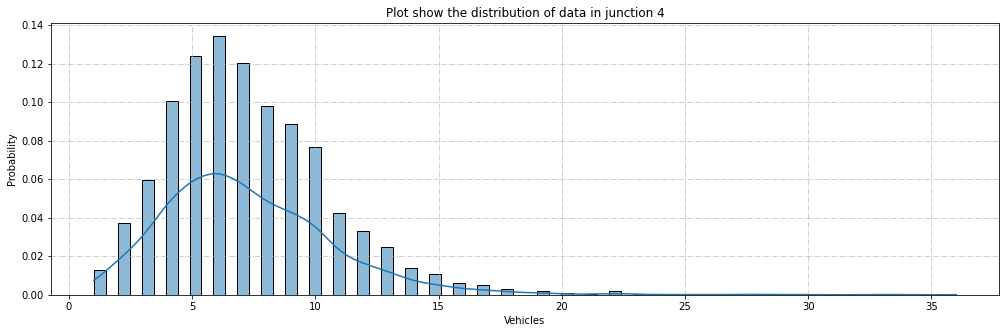

In [13]:
histogram(1)
histogram(2)
histogram(3)
histogram(4)

2. Plot the timeseries of junctions

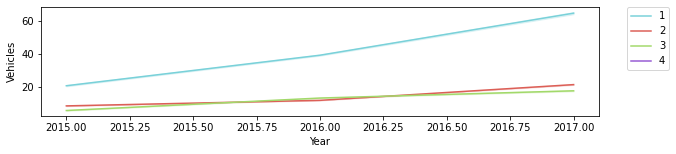

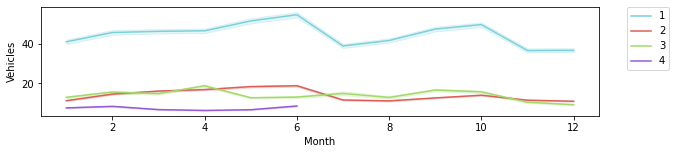

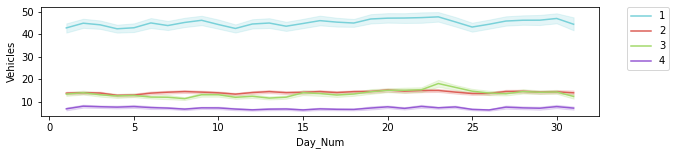

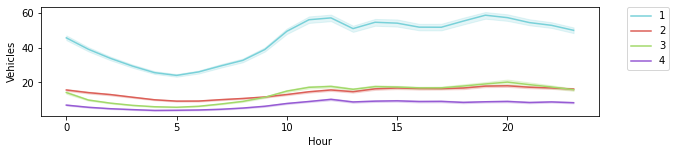

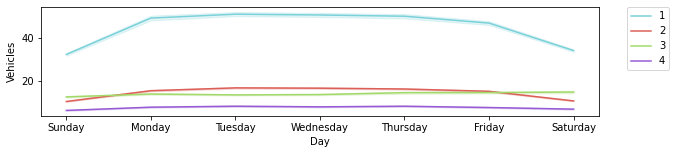

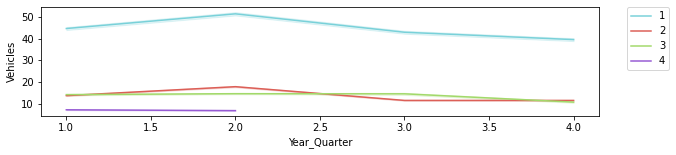

In [14]:
colors = [ "#79D1D9","#DC5F57","#A2D96A","#965BD4"]
df_date = [ "Year","Month", "Day_Num", "Hour", "Day", 'Year_Quarter']

for i in df_date:
    plt.figure(figsize=(10,2), facecolor="#FFFFFF")
    ax=sns.lineplot(x=df_traffic[i],y="Vehicles",data=df_traffic, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

3. Plots the number of Vehicles by Junction

Text(0.5, 0, 'DateTime')

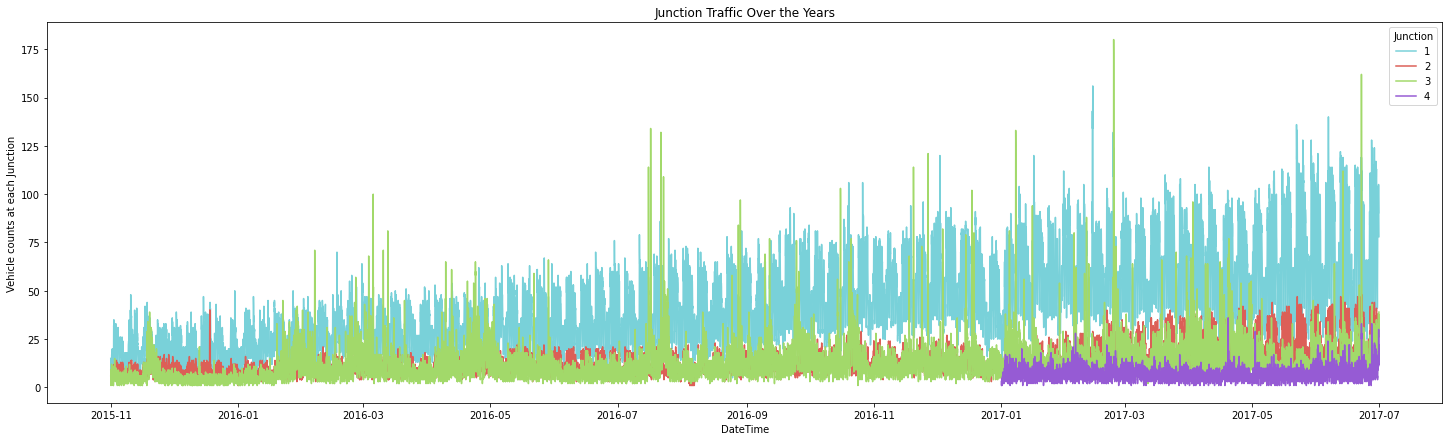

In [15]:
plt.figure(figsize=(25,7))

plot_y = sns.lineplot(x=df_traffic['DateTime'], y="Vehicles", data=df_traffic, hue="Junction", palette=colors)
plot_y.set_title("Junction Traffic Over the Years")
plot_y.set_ylabel("Vehicle counts at each Junction")
plot_y.set_xlabel("DateTime")

In [16]:
df = df_traffic.pivot(columns="Junction", index="DateTime")
df.describe()

Vehicles                                                   Year  \
Junction             1             2             3            4             1   
count     14592.000000  14592.000000  14592.000000  4344.000000  14592.000000   
mean         45.052906     14.253221     13.694010     7.251611   2016.197368   
std          23.008345      7.401307     10.436005     3.521455      0.599247   
min           5.000000      1.000000      1.000000     1.000000   2015.000000   
25%          27.000000      9.000000      7.000000     5.000000   2016.000000   
50%          40.000000     13.000000     11.000000     7.000000   2016.000000   
75%          59.000000     17.000000     18.000000     9.000000   2017.000000   
max         156.000000     48.000000    180.000000    36.000000   2017.000000   

                                                     Month                ...  \
Junction             2             3       4             1             2  ...   
count     14592.000000  14592.000000  4344.0  14592.000000  14592.000000  ...   
mean       2016.197368   2016.197368  2017.0      6.120066      6.120066  ...   
std           0.599247      0.599247     0.0      3.619842      3.619842  ...   
min        2015.000000   2015.000000  2017.0      1.000000      1.000000  ...   
25%        2016.000000   2016.000000  2017.0      3.000000      3.000000  ...   
50%        2016.000000   2016.000000  2017.0      6.000000      6.000000  ...   
75%        2017.000000   2017.000000  2017.0     10.000000     10.000000  ...   
max        2017.000000   2017.000000  2017.0     12.000000     12.000000  ...   

               Day_Num                       Hour                              \
Junction             3            4             1             2             3   
count     14592.000000  4344.000000  14592.000000  14592.000000  14592.000000   
mean         15.710526    15.602210     11.500000     11.500000     11.500000   
std           8.789036     8.736328      6.922424      6.922424      6.922424   
min           1.000000     1.000000      0.000000      0.000000      0.000000   
25%           8.000000     8.000000      5.750000      5.750000      5.750000   
50%          16.000000    16.000000     11.500000     11.500000     11.500000   
75%          23.000000    23.000000     17.250000     17.250000     17.250000   
max          31.000000    31.000000     23.000000     23.000000     23.000000   

                       Year_Quarter                                           
Junction            4             1             2             3            4  
count     4344.000000  14592.000000  14592.000000  14592.000000  4344.000000  
mean        11.500000      2.356908      2.356908      2.356908     1.502762  
std          6.922983      1.152519      1.152519      1.152519     0.500050  
min          0.000000      1.000000      1.000000      1.000000     1.000000  
25%          5.750000      1.000000      1.000000      1.000000     1.000000  
50%         11.500000      2.000000      2.000000      2.000000     2.000000  
75%         17.250000      4.000000      4.000000      4.000000     2.000000  
max         23.000000      4.000000      4.000000      4.000000     2.000000  

[8 rows x 24 columns]

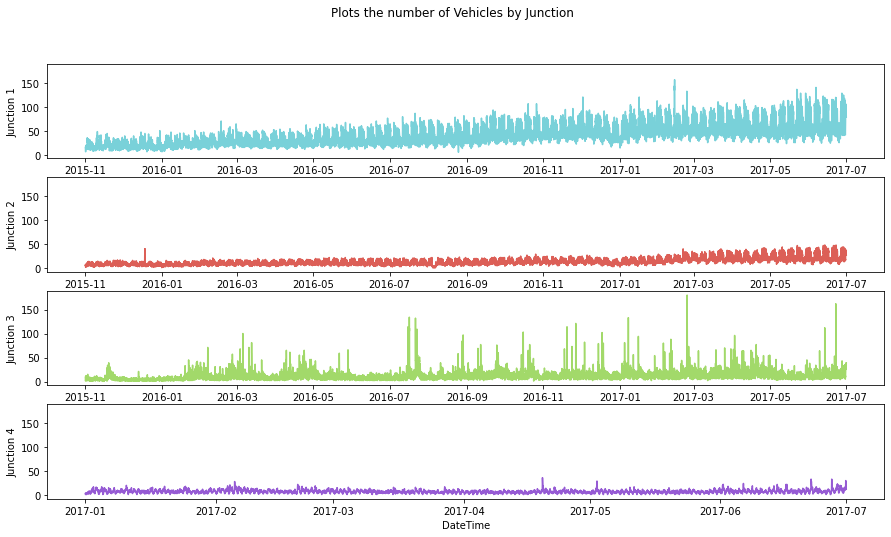

In [17]:
df_1 = df[[('Vehicles', 1)]].dropna()
df_2 = df[[('Vehicles', 2)]].dropna()
df_3 = df[[('Vehicles', 3)]].dropna()
df_4 = df[[('Vehicles', 4)]].dropna()


#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Plots the number of Vehicles by Junction")

In [18]:
df_1['Vehicles'].sum()

657412.0

In [19]:
df_2['Vehicles'].sum()

207983.0

In [20]:
df_3['Vehicles'].sum()

199823.0

In [21]:
df_4['Vehicles'].sum()

31501.0

4. Plot the Heatmap correlation

<AxesSubplot:>

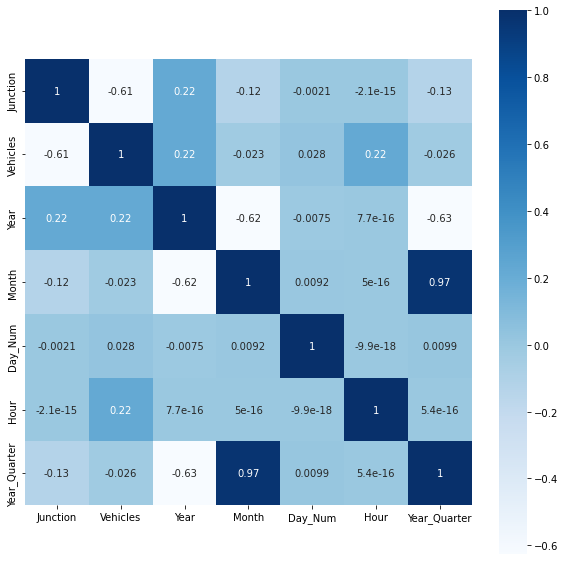

In [22]:
corrmat = df_traffic.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, cmap= "Blues",annot=True,square=True, )

5. Plot the pair plot

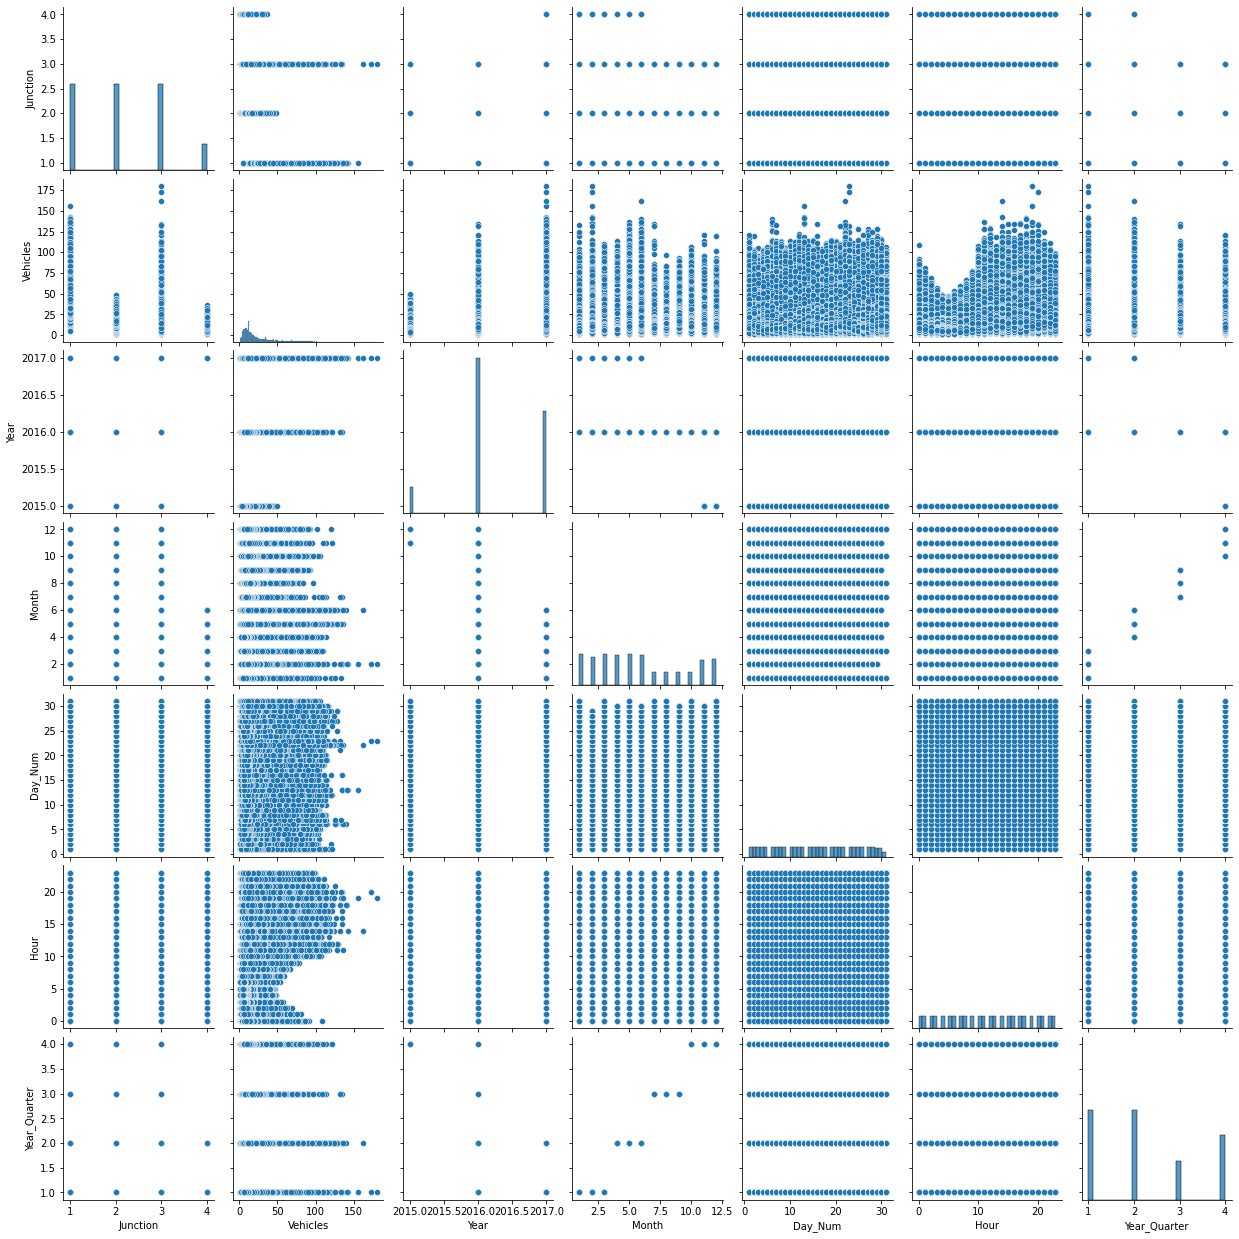

In [23]:
sns.pairplot(df_traffic)

***

## Normalization and Differencing

1. Normalization

In [24]:
def Normalizing(df,column):
    average = df[column].mean()
    stdev = df[column].std()
    df_normalized = (df[column] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev


def Difference(df,column, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[column][i] - df[column][i - interval]
        diff.append(value)
    return diff



#Normalizing and Differencing to make the series stationary 
df_N1, avg_J1, std_J1 = Normalizing(df_1, "Vehicles")
Diff_1 = Difference(df_N1, column="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, avg_J2, std_J2 = Normalizing(df_2, "Vehicles")
Diff_2 = Difference(df_N2, column="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, avg_J3, std_J3 = Normalizing(df_3, "Vehicles")
Diff_3 = Difference(df_N3, column="Vehicles", interval=(24)) #taking an day's diffrence
df_N3 = df_N3[24:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, avg_J4, std_J4 = Normalizing(df_4, "Vehicles")
Diff_4 = Difference(df_N4, column="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

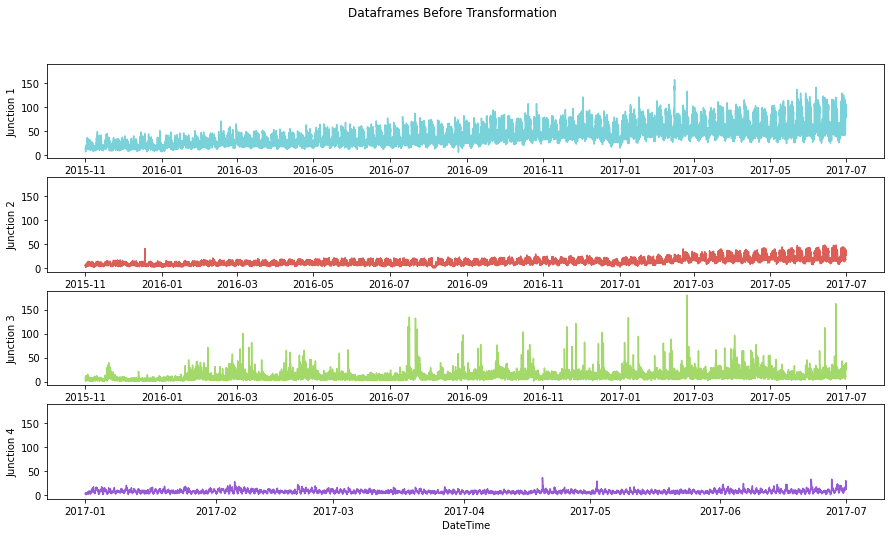

In [25]:
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4['Vehicles'],"Dataframes Before Transformation")

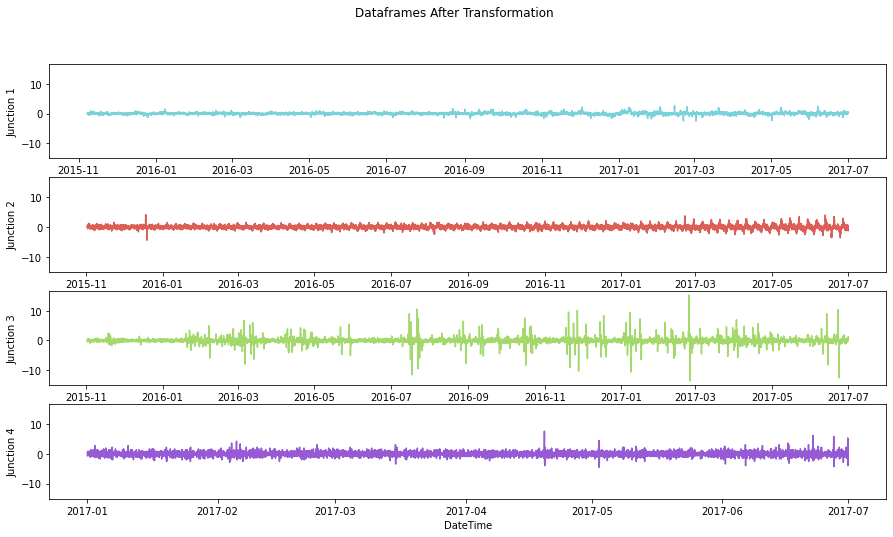

In [26]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

***

## Splitting data for training and testing sets

In [27]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna().to_frame()
df_J2 = df_N2["Diff"].dropna().to_frame()
df_J3 = df_N3["Diff"].dropna().to_frame()
df_J4 = df_N4["Diff"].dropna().to_frame()


#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.85)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 12
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TF(J1_train)
X_testJ1, y_testJ1 = TF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TF(J2_train)
X_testJ2, y_testJ2 = TF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TF(J3_train)
X_testJ3, y_testJ3 = TF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TF(J4_train)
X_testJ4, y_testJ4 = TF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [28]:
X_trainJ1.shape

(12248, 12, 1)

In [29]:
X_testJ1.shape

(2152, 12, 1)

In [30]:
X_trainJ2.shape

(12370, 12, 1)

In [31]:
X_testJ2.shape

(2174, 12, 1)

***

## Modeling

1. GRU model:

In [34]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True) 
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=35, batch_size=100,callbacks=[early_stopping])
    
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="Actual",alpha=0.5 )
    plt.plot(predicted,label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs Actual")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [35]:
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/35
123/123 [==============================] - 19s 74ms/step - loss: 0.0810
Epoch 2/35
123/123 [==============================] - 11s 86ms/step - loss: 0.0694
Epoch 3/35
123/123 [==============================] - 10s 83ms/step - loss: 0.0672
Epoch 4/35
123/123 [==============================] - 10s 78ms/step - loss: 0.0654
Epoch 5/35
123/123 [==============================] - 11s 92ms/step - loss: 0.0644
Epoch 6/35
123/123 [==============================] - 11s 87ms/step - loss: 0.0625
Epoch 7/35
123/123 [==============================] - 10s 81ms/step - loss: 0.0618
Epoch 8/35
123/123 [==============================] - 10s 83ms/step - loss: 0.0607
Epoch 9/35
123/123 [==============================] - 9s 76ms/step - loss: 0.0594
Epoch 10/35
123/123 [==============================] - 10s 78ms/step - loss: 0.0583
Epoch 11/35
123/123 [==============================] - 10s 79ms/step - loss: 0.0584
Epoch 12/35
123/123 [==============================] - 10s 78ms/step - loss: 0.0576
Ep

123/123 [==============================] - 10s 80ms/step - loss: 0.0499
Epoch 32/35
123/123 [==============================] - 9s 72ms/step - loss: 0.0498
Epoch 33/35
123/123 [==============================] - 9s 73ms/step - loss: 0.0499
Epoch 34/35
123/123 [==============================] - 9s 73ms/step - loss: 0.0495
Epoch 35/35
123/123 [==============================] - 9s 73ms/step - loss: 0.0489


The root mean squared error is  0.24487523078720472


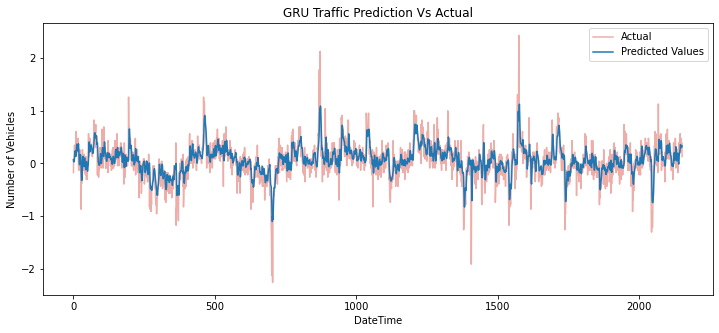

In [36]:
#Results for J1 
rmse1 = mean_squared_error(y_testJ1,PredJ1, squared=False)
print('The root mean squared error is ', rmse1)

PredictionsPlot(y_testJ1,PredJ1,1)

In [37]:
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/35
124/124 [==============================] - 22s 98ms/step - loss: 0.2312
Epoch 2/35
124/124 [==============================] - 11s 86ms/step - loss: 0.2080
Epoch 3/35
124/124 [==============================] - 11s 90ms/step - loss: 0.1978
Epoch 4/35
124/124 [==============================] - 11s 89ms/step - loss: 0.1926
Epoch 5/35
124/124 [==============================] - 11s 88ms/step - loss: 0.1931
Epoch 6/35
124/124 [==============================] - 10s 78ms/step - loss: 0.1906
Epoch 7/35
124/124 [==============================] - 10s 80ms/step - loss: 0.1906
Epoch 8/35
124/124 [==============================] - 10s 77ms/step - loss: 0.1868
Epoch 9/35
124/124 [==============================] - 10s 78ms/step - loss: 0.1881
Epoch 10/35
124/124 [==============================] - 10s 77ms/step - loss: 0.1866
Epoch 11/35
124/124 [==============================] - 10s 77ms/step - loss: 0.1857
Epoch 12/35
124/124 [==============================] - 10s 79ms/step - loss: 0.1850
E

124/124 [==============================] - 10s 79ms/step - loss: 0.1786
Epoch 32/35
124/124 [==============================] - 9s 73ms/step - loss: 0.1791
Epoch 33/35
124/124 [==============================] - 9s 73ms/step - loss: 0.1779
Epoch 34/35
124/124 [==============================] - 9s 72ms/step - loss: 0.1783
Epoch 35/35
124/124 [==============================] - 9s 74ms/step - loss: 0.1785


The root mean squared error is  0.5512067947997736


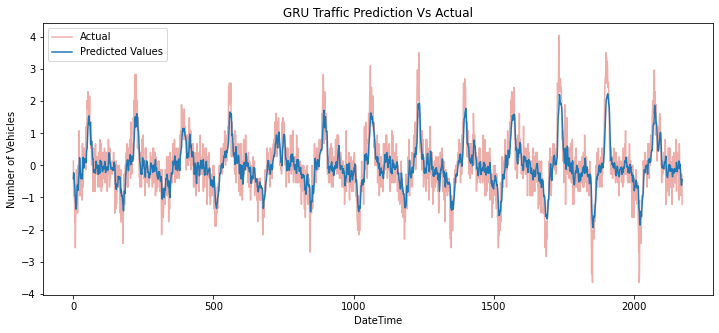

In [38]:
#Results for J2
rmse2 = mean_squared_error(y_testJ2,PredJ2, squared=False)
print('The root mean squared error is ', rmse2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [39]:
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)

Epoch 1/35
124/124 [==============================] - 18s 74ms/step - loss: 0.7979
Epoch 2/35
124/124 [==============================] - 10s 79ms/step - loss: 0.7424
Epoch 3/35
124/124 [==============================] - 9s 75ms/step - loss: 0.6822
Epoch 4/35
124/124 [==============================] - 10s 80ms/step - loss: 0.6290
Epoch 5/35
124/124 [==============================] - 10s 78ms/step - loss: 0.5623
Epoch 6/35
124/124 [==============================] - 9s 76ms/step - loss: 0.5329
Epoch 7/35
124/124 [==============================] - 10s 78ms/step - loss: 0.5153
Epoch 8/35
124/124 [==============================] - 9s 75ms/step - loss: 0.5121
Epoch 9/35
124/124 [==============================] - 10s 77ms/step - loss: 0.5006
Epoch 10/35
124/124 [==============================] - 10s 77ms/step - loss: 0.5000
Epoch 11/35
124/124 [==============================] - 10s 82ms/step - loss: 0.4941
Epoch 12/35
124/124 [==============================] - 10s 81ms/step - loss: 0.4880
Epoc

124/124 [==============================] - 11s 86ms/step - loss: 0.4754
Epoch 32/35
124/124 [==============================] - 11s 90ms/step - loss: 0.4775
Epoch 33/35
124/124 [==============================] - 12s 94ms/step - loss: 0.4772
Epoch 34/35
124/124 [==============================] - 11s 87ms/step - loss: 0.4788
Epoch 35/35
124/124 [==============================] - 10s 77ms/step - loss: 0.4764


The root mean squared error is  0.7290046164317637


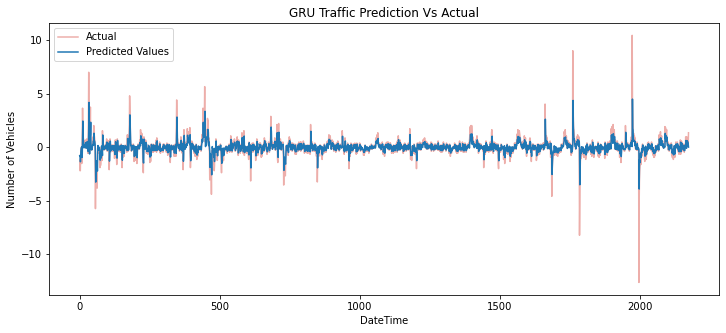

In [40]:
#Results for J3
rmse3 = mean_squared_error(y_testJ3,PredJ3, squared=False)
print('The root mean squared error is ', rmse3)
PredictionsPlot(y_testJ3,PredJ3,1)

In [41]:
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/35
37/37 [==============================] - 14s 109ms/step - loss: 0.6801
Epoch 2/35
37/37 [==============================] - 4s 97ms/step - loss: 0.6811
Epoch 3/35
37/37 [==============================] - 4s 102ms/step - loss: 0.6817
Epoch 4/35
37/37 [==============================] - 4s 104ms/step - loss: 0.6832
Epoch 5/35
37/37 [==============================] - 4s 100ms/step - loss: 0.6778
Epoch 6/35
37/37 [==============================] - 3s 86ms/step - loss: 0.6864
Epoch 7/35
37/37 [==============================] - 3s 88ms/step - loss: 0.6772
Epoch 8/35
37/37 [==============================] - 4s 95ms/step - loss: 0.6749
Epoch 9/35
37/37 [==============================] - 3s 93ms/step - loss: 0.6755
Epoch 10/35
37/37 [==============================] - 4s 108ms/step - loss: 0.6767
Epoch 11/35
37/37 [==============================] - 3s 89ms/step - loss: 0.6792
Epoch 12/35
37/37 [==============================] - 4s 103ms/step - loss: 0.6774
Epoch 13/35
37/37 [===========

Epoch 32/35
37/37 [==============================] - 3s 76ms/step - loss: 0.6719
Epoch 33/35
37/37 [==============================] - 3s 76ms/step - loss: 0.6715
Epoch 34/35
37/37 [==============================] - 3s 80ms/step - loss: 0.6734
Epoch 35/35
37/37 [==============================] - 3s 80ms/step - loss: 0.6719


The root mean squared error is  1.0377361555988784


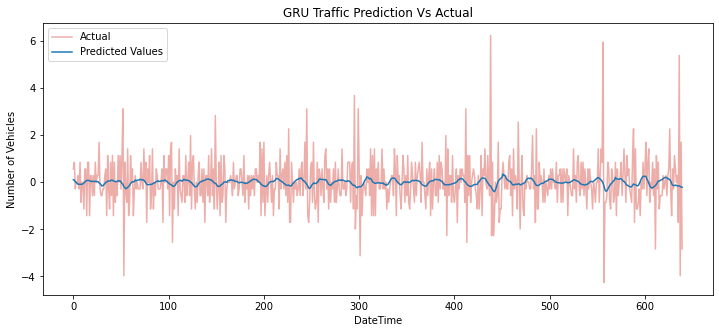

In [42]:
#Results for J4
rmse4 = mean_squared_error(y_testJ4,PredJ4, squared=False)
print('The root mean squared error is ', rmse4)
PredictionsPlot(y_testJ4,PredJ4,1)

In [43]:
print(rmse1,rmse2,rmse3,rmse4)

0.24487523078720472 0.5512067947997736 0.7290046164317637 1.0377361555988784


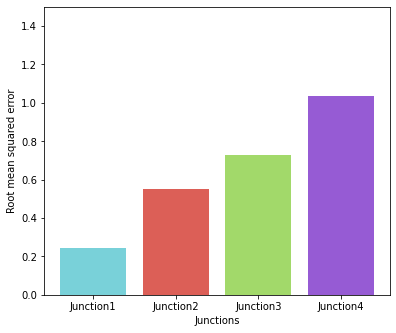

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.8,1])
rmses = [rmse1,rmse2,rmse3,rmse4]
junctions = ['Junction1','Junction2','Junction3','Junction4']
plt.xlabel("Junctions")
plt.ylabel("Root mean squared error")
plt.ylim(0, 1.5)
ax.bar(junctions,rmses,color=colors)
plt.show()